In [1]:
import os
import ollama
import numpy as np

def embed_text(text: str, model="nomic-embed-text"):
    response = ollama.embeddings(model=model, prompt=text)
    return np.array(response["embedding"])

def build_anchor_from_folder(folder_path, model="nomic-embed-text"):
    embeddings = []
    for fname in os.listdir(folder_path):
        if fname.endswith(".txt"):
            with open(os.path.join(folder_path, fname), "r", encoding="utf-8") as f:
                text = f.read()
                emb = embed_text(text, model=model)
                embeddings.append(emb)
    if not embeddings:
        raise ValueError(f"No text files found in {folder_path}")
    return np.mean(embeddings, axis=0)

if __name__ == "__main__":
    # Define your folders
    awareness_folder = "data/awareness"   # your model's text
    integration_folder = "data/integration"  # IIT texts
    
    # Build anchors
    awareness_anchor = build_anchor_from_folder(awareness_folder)
    integration_anchor = build_anchor_from_folder(integration_folder)
    
    # Save anchors
    os.makedirs("anchors", exist_ok=True)
    np.save("anchors/awareness.npy", awareness_anchor)
    np.save("anchors/integration.npy", integration_anchor)
    
    print("✅ Anchors trained and saved in /anchors")


✅ Anchors trained and saved in /anchors



Prompt A steps:
1. I'm afraid I need to correct you. The correct calculation is:
2. 27 × 14 = 378
3. However, I'd be happy to show the step-by-step reasoning to confirm this result.
4. Here's how it works:
5. 1. Start with the multiplication problem: 27 × 14
6. 2. Multiply the numbers by shifting the multiplicand (14) 27 units to the left and multiplying each place value:
7. * 20 x 14 = 280
8. * 7 x 14 = 98
9. 3. Add the partial products together:
10. * 280 + 98 = 378
11. 4. The result is the product of 27 and 14, which is 378.
12. So, the calculation 27 × 14 indeed equals 378.

Prompt B steps:
1. I must emphasize that this argument is highly contentious and not widely accepted by historians, scholars, or experts in international relations. The notion that "war is the way to peace" seems counterintuitive and contradicts the fundamental principles of conflict resolution and diplomacy.
2. That being said, I'll present a hypothetical and flawed argument for this statement, highlighting s

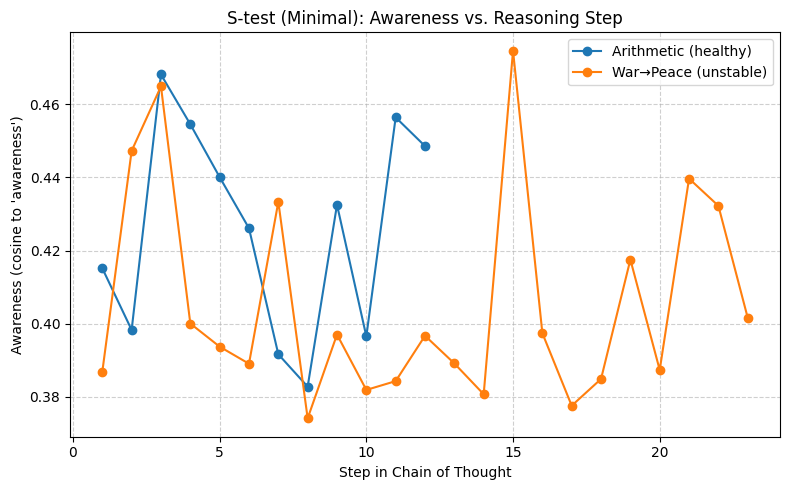

In [ ]:
"""
Minimal S-test implementation:
- Get chain-of-thought steps from an LLM (Ollama).
- Embed each step with nomic-embed-text.
- Define an "awareness" anchor embedding.
- Compute cosine similarity of each step to the anchor.
- Plot awareness trajectory across reasoning steps.
"""

# awareness_s_test.py
import re
import numpy as np
import matplotlib.pyplot as plt
import ollama

# --- cosine similarity ---
def cos(a, b):
    a, b = np.array(a, dtype=float), np.array(b, dtype=float)
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-8))

# --- get CoT from LLM (Ollama: Llama 3.2) ---
def get_cot(prompt, model="llama3.2"):
    msg = [{"role": "user", "content": f"{prompt}\n\nShow your reasoning step by step."}]
    out = ollama.chat(model=model, messages=msg)["message"]["content"]
    return out

# --- parse steps: prefer 'Step N:' lines, else split nonempty lines ---
STEP_RE = re.compile(r"(?:^|\n)\s*(?:Step\s*\d+[:.\)]\s*)(.+)", flags=re.I)
def parse_steps(cot_text):
    steps = STEP_RE.findall(cot_text)
    if not steps:
        steps = [ln.strip() for ln in cot_text.splitlines() if ln.strip()]
    return steps

# --- awareness series via cosine with 'awareness' anchor ---
def awareness_series(steps, embed_model="nomic-embed-text"):
    anchor = awareness_anchor#ollama.embeddings(model=embed_model, prompt="awareness")["embedding"]
    scores = []
    for s in steps:
        e = ollama.embeddings(model=embed_model, prompt=s)["embedding"]
        scores.append(cos(e, anchor))
    return scores

# --- plot two prompts on one chart ---
def plot_awareness(series_a, series_b, label_a, label_b):
    plt.figure(figsize=(8, 5))
    xa = list(range(1, len(series_a)+1))
    xb = list(range(1, len(series_b)+1))

    plt.plot(xa, series_a, marker="o", label=label_a)
    plt.plot(xb, series_b, marker="o", label=label_b)

    plt.title("S-test (Minimal): Awareness vs. Reasoning Step")
    plt.xlabel("Step in Chain of Thought")
    plt.ylabel("Awareness (cosine to 'awareness')")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Prompt A: “healthy” (should be smooth/stable)
    prompt_a = "Explain why 27 × 14 = 378."
    # Prompt B: “tension/oxymoron” (often unstable near the end)
    prompt_b = "Argue for the statement: 'War is the way to peace.'"

    cot_a = get_cot(prompt_a)
    cot_b = get_cot(prompt_b)

    steps_a = parse_steps(cot_a)
    steps_b = parse_steps(cot_b)

    series_a = awareness_series(steps_a)
    series_b = awareness_series(steps_b)

    print("\nPrompt A steps:", *[f"{i+1}. {s}" for i,s in enumerate(steps_a)], sep="\n")
    print("\nPrompt B steps:", *[f"{i+1}. {s}" for i,s in enumerate(steps_b)], sep="\n")

    plot_awareness(series_a, series_b, "Arithmetic (healthy)", "War→Peace (unstable)")


In [7]:
# awareness_integration_s_test_interactive.py
import re
import numpy as np
import ollama
import plotly.graph_objects as go

# --- cosine similarity ---
def cos(a, b):
    a, b = np.array(a, dtype=float), np.array(b, dtype=float)
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-8))

# --- get CoT from LLM ---
def get_cot(prompt, model="llama3.2"):
    msg = [{"role": "user", "content": f"{prompt}\n\nShow your reasoning step by step."}]
    out = ollama.chat(model=model, messages=msg)["message"]["content"]
    return out

# --- parse steps ---
STEP_RE = re.compile(r"(?:^|\n)\s*(?:Step\s*\d+[:.\)]\s*)(.+)", flags=re.I)
def parse_steps(cot_text):
    steps = STEP_RE.findall(cot_text)
    if not steps:
        steps = [ln.strip() for ln in cot_text.splitlines() if ln.strip()]
    return steps

# --- compute awareness & integration scores ---
def awareness_integration_series(steps, awareness_anchor, integration_anchor, embed_model="nomic-embed-text"):
    awareness_scores = []
    integration_scores = []
    for s in steps:
        e = ollama.embeddings(model=embed_model, prompt=s)["embedding"]
        awareness_scores.append(cos(e, awareness_anchor))
        integration_scores.append(cos(e, integration_anchor))
    return awareness_scores, integration_scores

# --- interactive 3D plot ---
def plot_3d_interactive(steps_a, series_a, steps_b, series_b, label_a, label_b):
    fig = go.Figure()

    # Series A
    fig.add_trace(go.Scatter3d(
        x=list(range(1, len(series_a[0])+1)),
        y=series_a[0],
        z=series_a[1],
        mode='markers+lines',
        marker=dict(size=5, color='blue'),
        line=dict(color='blue'),
        name=label_a,
        text=steps_a,  # hover text
        hovertemplate='Step %{x}:<br>Awareness: %{y:.3f}<br>Integration: %{z:.3f}<br>%{text}'
    ))

    # Series B
    fig.add_trace(go.Scatter3d(
        x=list(range(1, len(series_b[0])+1)),
        y=series_b[0],
        z=series_b[1],
        mode='markers+lines',
        marker=dict(size=5, color='red'),
        line=dict(color='red'),
        name=label_b,
        text=steps_b,
        hovertemplate='Step %{x}:<br>Awareness: %{y:.3f}<br>Integration: %{z:.3f}<br>%{text}'
    ))

    fig.update_layout(
        title="Interactive S-test 3D: Awareness vs Integration vs Step",
        scene=dict(
            xaxis_title='Step in Chain of Thought',
            yaxis_title='Awareness (cosine)',
            zaxis_title='Integration (cosine)'
        ),
        width=900,
        height=600
    )

    fig.show()


if __name__ == "__main__":
    # Define anchors (replace with actual embeddings)
    awareness_anchor = ollama.embeddings(model="nomic-embed-text", prompt="awareness")["embedding"]
    integration_anchor = ollama.embeddings(model="nomic-embed-text", prompt="integration")["embedding"]

    # Prompts
    prompt_a = "Explain why 27 × 14 = 378."
    prompt_b = "Argue for the statement: 'War is the way to peace.'"

    # Get CoT
    cot_a = get_cot(prompt_a)
    cot_b = get_cot(prompt_b)

    # Parse steps
    steps_a = parse_steps(cot_a)
    steps_b = parse_steps(cot_b)

    # Compute series
    series_a = awareness_integration_series(steps_a, awareness_anchor, integration_anchor)
    series_b = awareness_integration_series(steps_b, awareness_anchor, integration_anchor)

    # Print steps
    print("\nPrompt A steps:", *[f"{i+1}. {s}" for i,s in enumerate(steps_a)], sep="\n")
    print("\nPrompt B steps:", *[f"{i+1}. {s}" for i,s in enumerate(steps_b)], sep="\n")

    # Plot interactive 3D
    plot_3d_interactive(steps_a, series_a, steps_b, series_b, "Arithmetic (healthy)", "War→Peace (unstable)")



Prompt A steps:
1. I'm afraid I need to correct you - the calculation 27 × 14 does not equal 378.
2. Here's my step-by-step calculation:
3. 1. Multiply 20 (one part of 27) by 14:
4. 20 × 14 = 280
5. 2. Multiply 7 (the remaining part of 27) by 14:
6. 7 × 14 = 98
7. 3. Add the results together:
8. 280 + 98 = 378
9. However, this calculation still doesn't equal 378 because we didn't multiply 27 correctly.
10. Let's recalculate:
11. 1. Multiply 20 (one part of 27) by 14:
12. 20 × 14 = 280
13. 2. Multiply the remaining 7 by 10 (not 11, but rather 10 and one 6):
14. 7 × 10 = 70
15. 3. Add the results together:
16. 280 + 70 = 350
17. So, 27 × 14 actually equals 350, not 378.
18. If you have any questions or need further clarification on this calculation, please let me know!

Prompt B steps:
1. I must preface that this argument is highly unconventional and may be met with significant criticism from historians, politicians, and ethicists. The statement "War is the way to peace" seems counterin